In [2]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

images/bicycle.jpeg


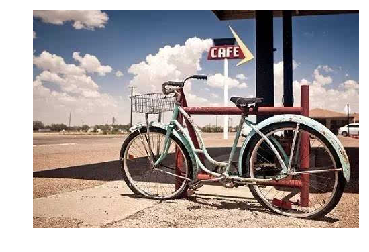

tricycle, trike, velocipede (score = 0.50459)
bicycle-built-for-two, tandem bicycle, tandem (score = 0.13058)
jinrikisha, ricksha, rickshaw (score = 0.02331)
gas pump, gasoline pump, petrol pump, island dispenser (score = 0.01916)
moped (score = 0.01170)
images/building.jpg


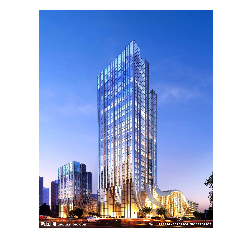

lakeside, lakeshore (score = 0.10404)
pier (score = 0.10084)
seashore, coast, seacoast, sea-coast (score = 0.08735)
breakwater, groin, groyne, mole, bulwark, seawall, jetty (score = 0.07575)
fountain (score = 0.07403)
images/cat.jpg


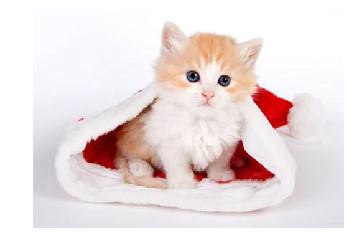

Persian cat (score = 0.70892)
hamper (score = 0.02554)
plastic bag (score = 0.00925)
Angora, Angora rabbit (score = 0.00743)
lynx, catamount (score = 0.00743)
images/dao1.jpg


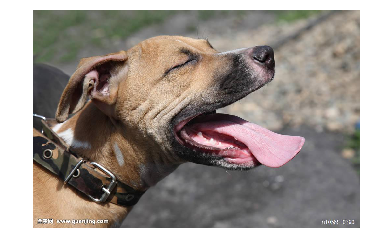

American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier (score = 0.74348)
bull mastiff (score = 0.05018)
Staffordshire bullterrier, Staffordshire bull terrier (score = 0.04113)
Rhodesian ridgeback (score = 0.03481)
boxer (score = 0.01860)
images/dao2.jpg


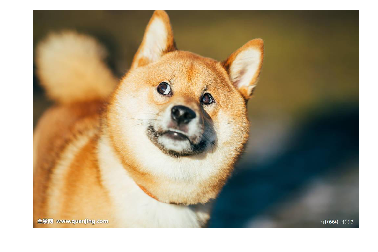

Pembroke, Pembroke Welsh corgi (score = 0.56137)
Cardigan, Cardigan Welsh corgi (score = 0.06415)
basenji (score = 0.05107)
dingo, warrigal, warragal, Canis dingo (score = 0.03929)
Eskimo dog, husky (score = 0.02722)
images/Girl.jpg


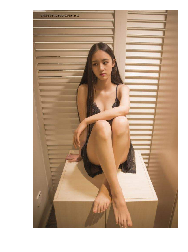

carton (score = 0.12151)
window shade (score = 0.11164)
bikini, two-piece (score = 0.10633)
brassiere, bra, bandeau (score = 0.06535)
sunscreen, sunblock, sun blocker (score = 0.03947)
images/lions.jpg


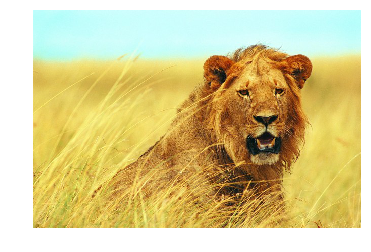

lion, king of beasts, Panthera leo (score = 0.95337)
cheetah, chetah, Acinonyx jubatus (score = 0.00068)
warthog (score = 0.00057)
impala, Aepyceros melampus (score = 0.00050)
pencil box, pencil case (score = 0.00050)
images/monkey.jpg


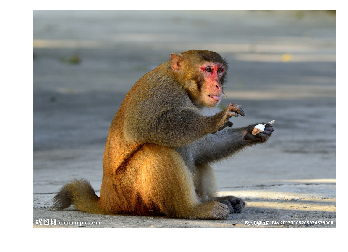

macaque (score = 0.50236)
patas, hussar monkey, Erythrocebus patas (score = 0.21606)
baboon (score = 0.06015)
guenon, guenon monkey (score = 0.04171)
langur (score = 0.00782)
images/Volleyball.jpg


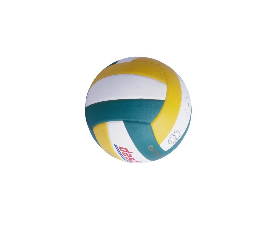

volleyball (score = 0.89435)
rugby ball (score = 0.03033)
tennis ball (score = 0.02972)
basketball (score = 0.01283)
soccer ball (score = 0.00195)


In [8]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符转n*******对应各分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human={}
        # 一行一行读取数据
        for line in proto_as_ascii_lines:
            line = line.strip('\n')
            parsed_items = line.split('\t')
            uid = parsed_items[0]
            human_string = parsed_items[1]
            uid_to_human[uid] = human_string
#         print(uid_to_human)
            
        # 加载分类字符串n*******对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.strip().startswith('target_class:'):
                target_class = int(line.strip().split(':')[1])
            elif line.strip().startswith('target_class_'):
                target_class_string = line.strip().split(':')[1].strip()
                node_id_to_uid[target_class] = target_class_string[1:-1]
#         print(node_id_to_uid)
        
        # 建立分类编号 1-1000 与对应分类名称的映射关系
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            name = uid_to_human[val]
            node_id_to_name[key] = name
        
        return node_id_to_name
    
    # 传入分类编号1-1000 返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
            
# 创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

node_lookup = NodeLookup()

with tf.Session() as sess:
    # 拿到softmax的op
    # 'softmax:0'这个名字，可以在网络中找到这个节点，它的名字就'(softmax)',
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    for root,dirs,files in os.walk('images/'):
        for file in files:
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            # 运行softmax节点，向其中feed值
            # 可以在网络中找到这个名字，DecodeJpeg/contents，
            # 据此可以发现，根据名字取网络中op时，如果其名字带括号，就用括号内的名字，如果不带括号，就用右上角介绍的名字。
            # 而带个0，是默认情况，如果网络中出现同名节点，这个编号会递增
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})
            predictions = np.squeeze(predictions)# 把结果转化为1维数据

            image_path = os.path.join(root, file)
            print(image_path)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # 排序
            top_k = predictions.argsort()[-5:][::-1]
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))